In [5]:
!unzip /content/drive/MyDrive/dogs-vs-cats.zip

Archive:  /content/drive/MyDrive/dogs-vs-cats.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [11]:
!unzip /content/test1.zip
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [12]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [14]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [16]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [17]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs=EPOCHS,
                              verbose=1)

<ipython-input-17-c516ba2fb733>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
10/10 [==============================] - 12s 582ms/step - loss: 0.8518 - acc: 0.4920 - val_loss: 0.6931 - val_acc: 0.4940
Epoch 2/50
10/10 [==============================] - 7s 667ms/step - loss: 0.6935 - acc: 0.5170 - val_loss: 0.6926 - val_acc: 0.5140
Epoch 3/50
10/10 [==============================] - 7s 669ms/step - loss: 0.6934 - acc: 0.5140 - val_loss: 0.6922 - val_acc: 0.5080
Epoch 4/50
10/10 [==============================] - 7s 665ms/step - loss: 0.6926 - acc: 0.4990 - val_loss: 0.6915 - val_acc: 0.4940
Epoch 5/50
10/10 [==============================] - 7s 667ms/step - loss: 0.6904 - acc: 0.5520 - val_loss: 0.6894 - val_acc: 0.4960
Epoch 6/50
10/10 [==============================] - 7s 673ms/step - loss: 0.7006 - acc: 0.5290 - val_loss: 0.6932 - val_acc: 0.5060
Epoch 7/50
10/10 [==============================] - 7s 663ms/step - loss: 0.6928 - acc: 0.5170 - val_loss: 0.6923 - val_acc: 0.4980
Epoch 8/50
10/10 [==============================] - 7s 671ms/step - loss: 0

Text(0.5, 1.0, 'Training and validation loss')

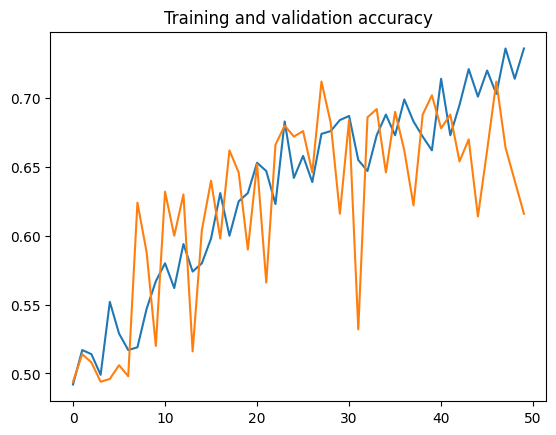

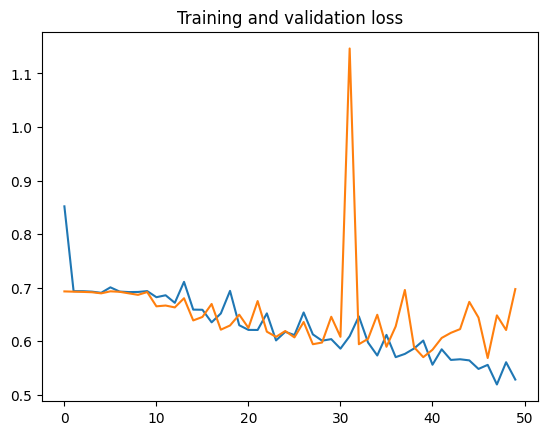

In [18]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [19]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-19-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.7118976712226868
Test Accuracy: 0.6039999723434448


Data Augmentation

In [20]:
# Augmentation settings for training data
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # rescale should be included in data augmentation for consistency
)

# Apply data augmentation to the subset of 1000 training samples
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 1000 validated image filenames belonging to 2 classes.


In [21]:

# Now, fit the model using the augmented data generator
history_augmented = model.fit_generator(
    train_generator_augmented,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator_augmented),
    validation_steps=len(valid_generator),
    epochs=EPOCHS,
    verbose=1
)

<ipython-input-21-72661682a0bc>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_augmented = model.fit_generator(


Epoch 1/50
10/10 [==============================] - 7s 688ms/step - loss: 0.5521 - acc: 0.7030 - val_loss: 0.5579 - val_acc: 0.7240
Epoch 2/50
10/10 [==============================] - 7s 665ms/step - loss: 0.5357 - acc: 0.7340 - val_loss: 0.5773 - val_acc: 0.7100
Epoch 3/50
10/10 [==============================] - 7s 672ms/step - loss: 0.5464 - acc: 0.7140 - val_loss: 0.5544 - val_acc: 0.7260
Epoch 4/50
10/10 [==============================] - 7s 661ms/step - loss: 0.5503 - acc: 0.7070 - val_loss: 0.5716 - val_acc: 0.7100
Epoch 5/50
10/10 [==============================] - 7s 668ms/step - loss: 0.5427 - acc: 0.7240 - val_loss: 0.5552 - val_acc: 0.7160
Epoch 6/50
10/10 [==============================] - 7s 667ms/step - loss: 0.5413 - acc: 0.7210 - val_loss: 0.5536 - val_acc: 0.7060
Epoch 7/50
10/10 [==============================] - 7s 660ms/step - loss: 0.5468 - acc: 0.7180 - val_loss: 0.5451 - val_acc: 0.7300
Epoch 8/50
10/10 [==============================] - 7s 660ms/step - loss: 0.

Text(0.5, 1.0, 'Training and validation loss')

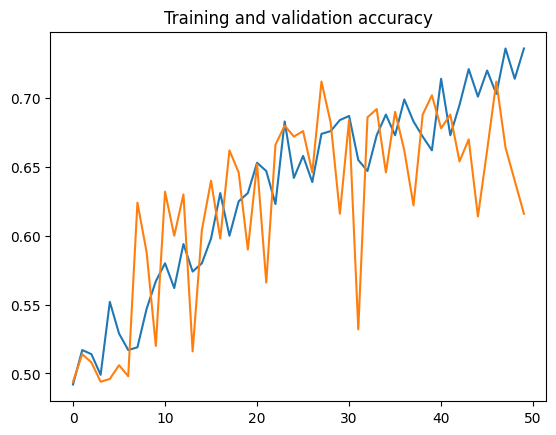

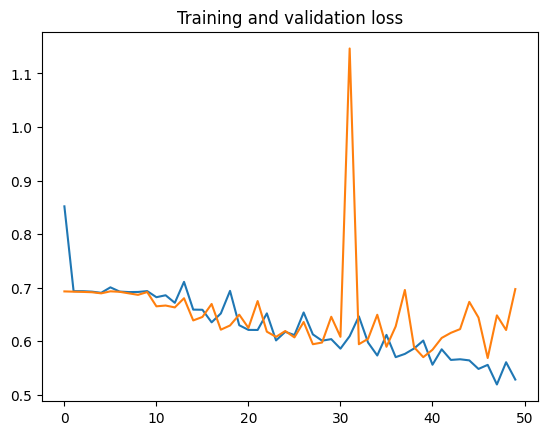

In [22]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [23]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-23-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.4889286458492279
Test Accuracy: 0.777999997138977


Increasing training size to 5000 and keeping remaining as same

In [24]:
TOTAL_TRAIN_SIZE = 5000  # Total number of training samples
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [25]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [27]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [28]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs=EPOCHS,
                              verbose=1)

<ipython-input-28-c516ba2fb733>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
50/50 [==============================] - 31s 593ms/step - loss: 0.7136 - acc: 0.5118 - val_loss: 0.6894 - val_acc: 0.6020
Epoch 2/50
50/50 [==============================] - 30s 601ms/step - loss: 0.6940 - acc: 0.5292 - val_loss: 0.6855 - val_acc: 0.6120
Epoch 3/50
50/50 [==============================] - 30s 607ms/step - loss: 0.6903 - acc: 0.5390 - val_loss: 0.6778 - val_acc: 0.6040
Epoch 4/50
50/50 [==============================] - 30s 599ms/step - loss: 0.6818 - acc: 0.5648 - val_loss: 0.6607 - val_acc: 0.5640
Epoch 5/50
50/50 [==============================] - 30s 597ms/step - loss: 0.6662 - acc: 0.5790 - val_loss: 0.6236 - val_acc: 0.6600
Epoch 6/50
50/50 [==============================] - 30s 601ms/step - loss: 0.6585 - acc: 0.6094 - val_loss: 0.6448 - val_acc: 0.6440
Epoch 7/50
50/50 [==============================] - 30s 602ms/step - loss: 0.6376 - acc: 0.6298 - val_loss: 0.7846 - val_acc: 0.5540
Epoch 8/50
50/50 [==============================] - 30s 598ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

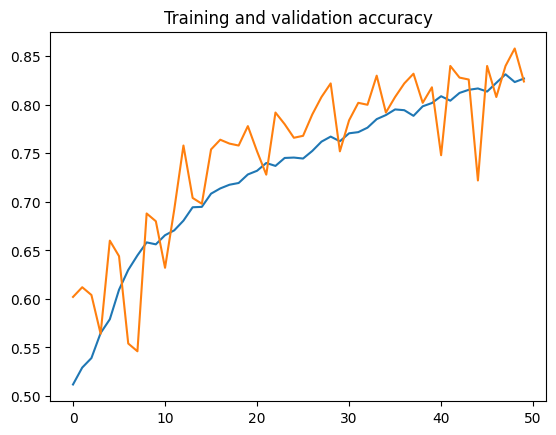

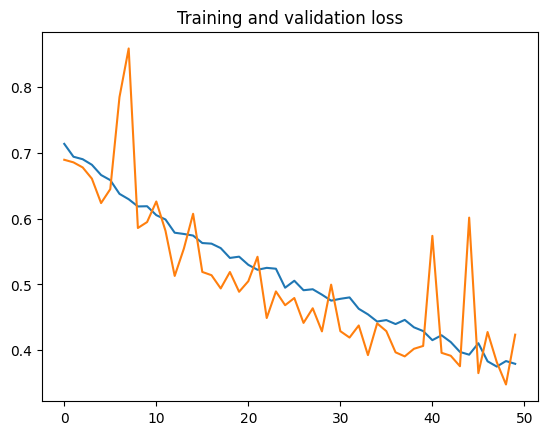

In [29]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [30]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-30-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.4014872610569
Test Accuracy: 0.8320000171661377


In [31]:
# Augmentation settings for training data
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # rescale should be included in data augmentation for consistency
)

# Apply data augmentation to the subset of 1000 training samples
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [32]:
# Now, fit the model using the augmented data generator
history_augmented = model.fit_generator(
    train_generator_augmented,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator_augmented),
    validation_steps=len(valid_generator),
    epochs=EPOCHS,
    verbose=1
)

<ipython-input-32-72661682a0bc>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_augmented = model.fit_generator(


Epoch 1/50
50/50 [==============================] - 30s 596ms/step - loss: 0.3580 - acc: 0.8400 - val_loss: 0.3959 - val_acc: 0.8200
Epoch 2/50
50/50 [==============================] - 30s 596ms/step - loss: 0.3661 - acc: 0.8358 - val_loss: 0.3942 - val_acc: 0.8180
Epoch 3/50
50/50 [==============================] - 30s 591ms/step - loss: 0.3755 - acc: 0.8330 - val_loss: 0.3324 - val_acc: 0.8500
Epoch 4/50
50/50 [==============================] - 30s 593ms/step - loss: 0.3508 - acc: 0.8394 - val_loss: 0.4204 - val_acc: 0.8080
Epoch 5/50
50/50 [==============================] - 30s 592ms/step - loss: 0.3627 - acc: 0.8332 - val_loss: 0.4012 - val_acc: 0.8160
Epoch 6/50
50/50 [==============================] - 30s 595ms/step - loss: 0.3479 - acc: 0.8432 - val_loss: 0.3333 - val_acc: 0.8640
Epoch 7/50
50/50 [==============================] - 30s 595ms/step - loss: 0.3428 - acc: 0.8418 - val_loss: 0.3703 - val_acc: 0.8520
Epoch 8/50
50/50 [==============================] - 30s 593ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

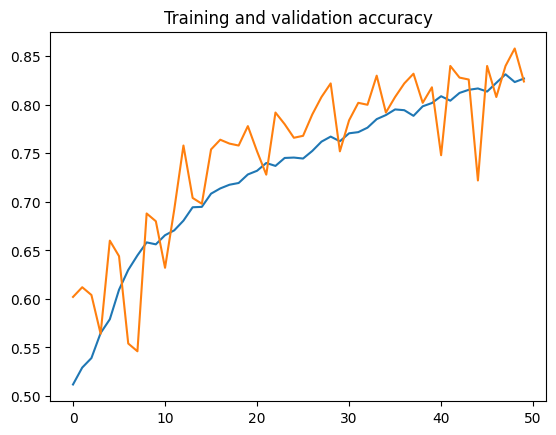

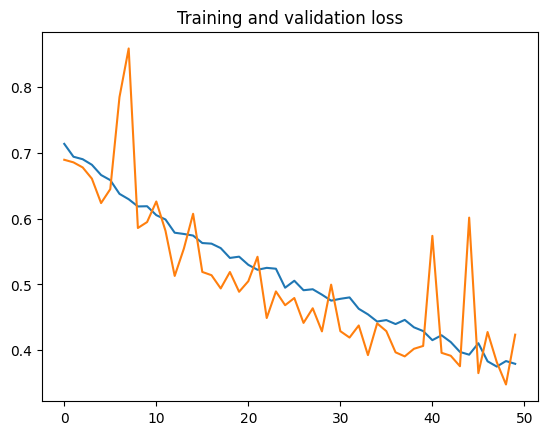

In [33]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [34]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-34-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.28465840220451355
Test Accuracy: 0.8920000195503235


In [35]:
TOTAL_TRAIN_SIZE = 10000
VALID_SIZE = 2000
TEST_SIZE = 2000

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# Creating dataframe with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# Augmentation settings for training data
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Data generators
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [36]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))   # Dropout layer with dropout rate of 50%
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))   # Dropout layer with dropout rate of 50%
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)       

In [38]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [39]:
# Now, fit the model using the augmented data generator
history_augmented = model.fit_generator(
    train_generator_augmented,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator_augmented),
    validation_steps=len(valid_generator),
    epochs=EPOCHS,
    verbose=1
)

<ipython-input-39-72661682a0bc>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_augmented = model.fit_generator(


Epoch 1/50
100/100 [==============================] - 64s 598ms/step - loss: 0.7200 - acc: 0.5057 - val_loss: 0.6920 - val_acc: 0.5695
Epoch 2/50
100/100 [==============================] - 61s 611ms/step - loss: 0.6884 - acc: 0.5351 - val_loss: 0.6798 - val_acc: 0.5745
Epoch 3/50
100/100 [==============================] - 61s 605ms/step - loss: 0.6774 - acc: 0.5694 - val_loss: 0.6667 - val_acc: 0.5540
Epoch 4/50
100/100 [==============================] - 61s 608ms/step - loss: 0.6482 - acc: 0.6159 - val_loss: 0.5910 - val_acc: 0.6755
Epoch 5/50
100/100 [==============================] - 61s 607ms/step - loss: 0.6460 - acc: 0.6218 - val_loss: 0.6262 - val_acc: 0.6395
Epoch 6/50
100/100 [==============================] - 61s 607ms/step - loss: 0.6330 - acc: 0.6447 - val_loss: 0.5926 - val_acc: 0.6495
Epoch 7/50
100/100 [==============================] - 61s 607ms/step - loss: 0.6319 - acc: 0.6503 - val_loss: 0.5785 - val_acc: 0.6860
Epoch 8/50
100/100 [==============================] - 6

Text(0.5, 1.0, 'Training and validation loss')

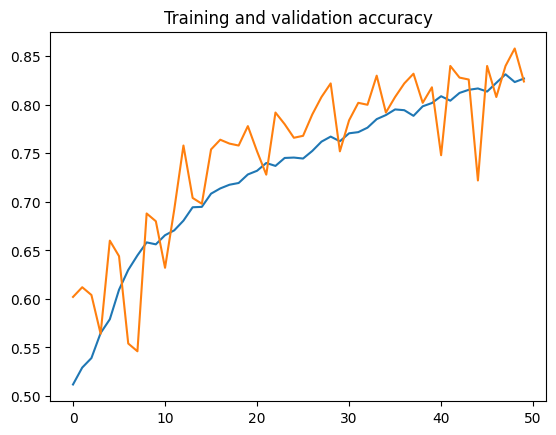

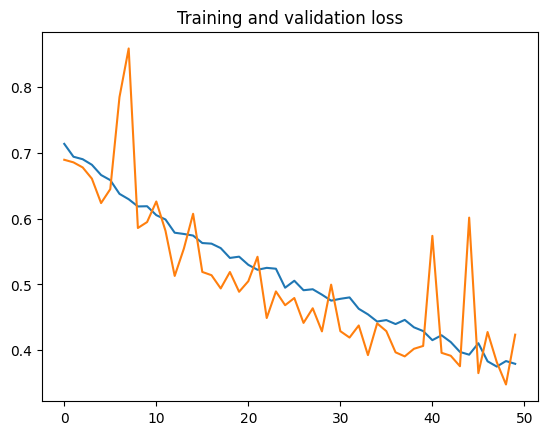

In [40]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [41]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-41-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.25816890597343445
Test Accuracy: 0.890500009059906


In [42]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [69]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // BATCH_SIZE
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               2097408   
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 8s 667ms/step - loss: 1.2067 - accuracy: 0.5650 - val_loss: 0.6858 - val_accuracy: 0.612

Text(0.5, 1.0, 'Training and validation loss')

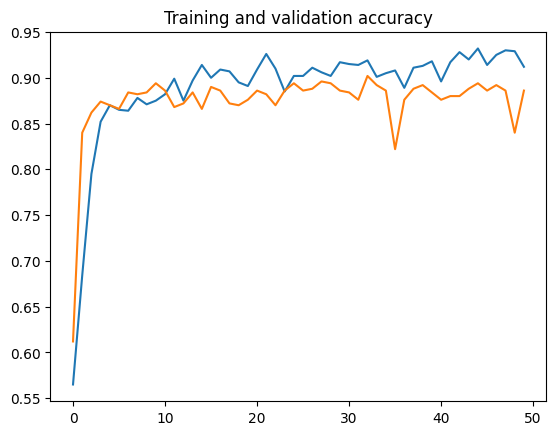

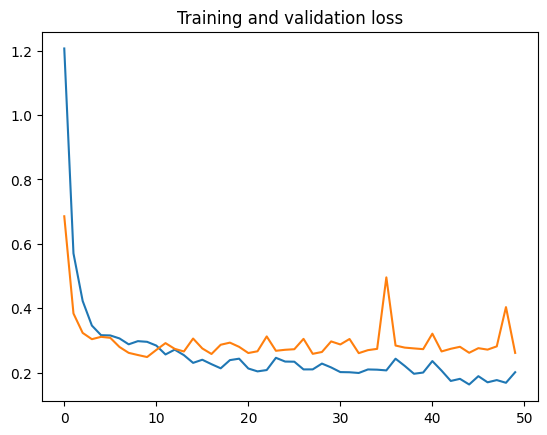

In [71]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [72]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-72-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.25889092683792114
Test Accuracy: 0.8859999775886536


In [81]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [82]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // BATCH_SIZE
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               2097408   
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 8s 695ms/step - loss: 1.6111 - accuracy: 0.5420 - val_loss: 0.7320 - val_accuracy: 0.498

Text(0.5, 1.0, 'Training and validation loss')

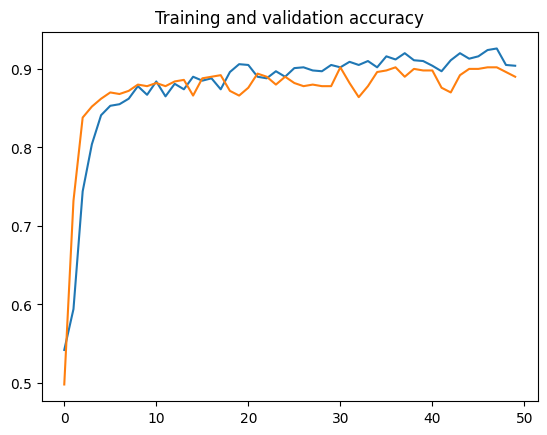

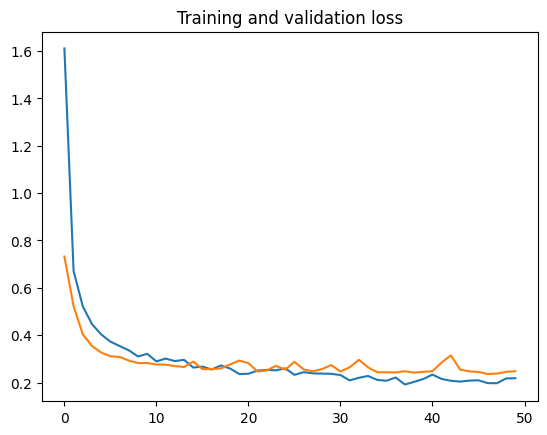

In [83]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [84]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-84-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.25168532133102417
Test Accuracy: 0.8899999856948853


In [77]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 3000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 3000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [78]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // BATCH_SIZE
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 20s 622ms/step - loss: 0.8135 - accuracy: 0.6697 - val_loss: 0.3599 - val_accuracy: 0.84

Text(0.5, 1.0, 'Training and validation loss')

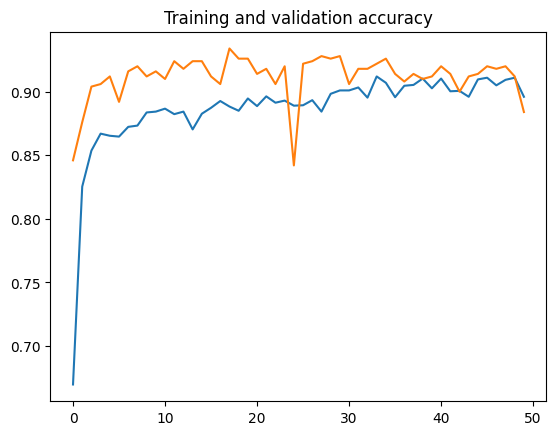

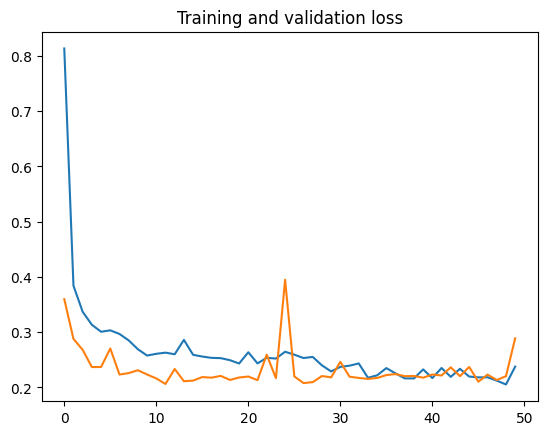

In [79]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [80]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-80-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.2880970239639282
Test Accuracy: 0.8840000033378601


In [85]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 15000
VALID_SIZE = 3000
TEST_SIZE = 3000

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 15000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


In [86]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // BATCH_SIZE
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 8192)              0         
                                                                 
 dropout_6 (Dropout)         (None, 8192)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               2097408   
                                                                 
 dense_27 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/

Text(0.5, 1.0, 'Training and validation loss')

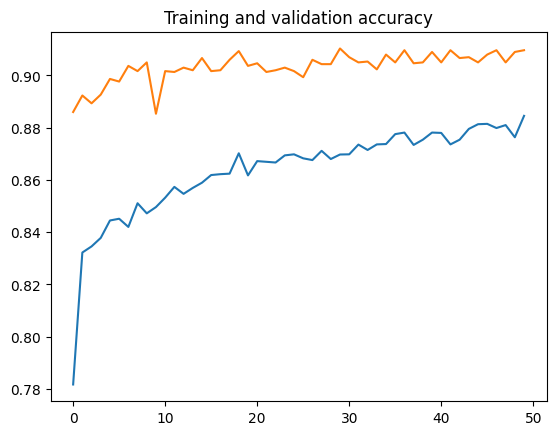

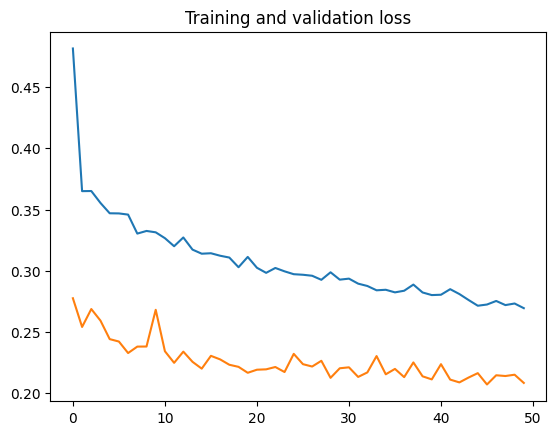

In [87]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [88]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

<ipython-input-88-4edd98f656fd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.2073771357536316
Test Accuracy: 0.9173333048820496
